# Анализ качества алгоритмической цепочки для построения неинвазивных биомаркеров для пациентов с глиомами головного мозга

_____

In [39]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Исходный программный код для этого Jupyter ноутбука скрыт, 
чтобы отобразить его, нажмите 
<a href="javascript:code_toggle()">сюда</a>.''')

_____

### Установка библиотеки medim

In [2]:
# устанавливаем к себе библиотеку medim
!ln -s ${HOME}/mik_imgs/medim/medim/ ${HOME}/anaconda3/lib/python3.6/site-packages/medim

### Импортирование необходимых библиотек

In [3]:
import gc

from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import medim
import tfmod
from data_loaders import Brats2015, Brats2017
from utils import *
from tools import train_model, find_threshold, get_stats_and_dices

%matplotlib inline
# %load_ext autoreload
# %autoreload 2
# %load_ext line_profiler

### указание всех необходимых путей к моделям и данным

In [4]:
path_to_models = '/home/mount/neuro-t01-ssd/home/krivov/medim/projects/brats2017/checkpoints/'
log_path = '~/tmp/tf'
processed_path = '/home/mount/neuro-x02-ssd/brats2017/processed'

### Указание параметров обучения, определение вспомогательных функций.

In [5]:
n_epoch = 100

kernel_size = 3
patch_size_x_det = np.array([25, 25, 25])
patch_size_x_con = np.array([19, 19, 19]) * 3

patch_size_y = np.array([5, 5, 5])

x_det_padding = (patch_size_x_det - patch_size_y) // 2
x_con_padding = (patch_size_x_con - patch_size_y) // 2

def make_val_inputs(x, y):
    val_inputs = []
    for xo, yo in zip(x, y):
        val_inputs.extend(get_val_deepmedic(xo, yo, x_det_padding, x_con_padding))
    return val_inputs

def get_pred_and_true(model_controller, xo, yo):
    inputs = get_val_deepmedic(xo, yo, x_det_padding, x_con_padding)
    
    yo_pred = []
    yo_true = []
    for xo_det, xo_con, yo_con in inputs:
        yo_pred.append(model_controller.predict_proba([xo_det, xo_con]))
        yo_true.append(yo_con)
        
    yo_pred = medim.utils.combine(yo_pred, [1, 1, 2, 1])
    yo_true = medim.utils.combine(yo_true, [1, 2, 1])
    return yo_pred, yo_true

def make_batch_iterator(x, y, batch_size):
    train_iter = medim.batch_iter.patch.foreground(
        [x, x, y], [patch_size_x_det, patch_size_x_con,patch_size_y],
        batch_size=batch_size,
        spatial_dims=(-3, -2, -1), f_fraction=0.5, f_condition=lambda y: y > 0,
    )
    return train_iter

### Загрузка, разделение данных для кросс-валидации

In [6]:
data_loader = Brats2017(processed_path)

patients = data_loader.patients
metadata = data_loader.metadata

spatial_size = data_loader.spatial_size
n_modalities = data_loader.n_modalities
n_chans_msegm = data_loader.n_chans_msegm
n_classes = data_loader.n_classes

train, train_val, val, test = split_data(metadata)

sd_train = metadata.iloc[train].survival_class.values
sd_train_val = metadata.iloc[train_val].survival_class.values
sd_val = metadata.iloc[val].survival_class.values
sd_test = metadata.iloc[test].survival_class.values

### Построение (обучение) и сохранение моделей.

In [ ]:
for ds, (val_set, test_set) in enumerate([[val, test], [test, val]]):
    for i in range(2):
        tf.reset_default_graph()
        model = tfmod.models.DeepMedic(n_modalities, n_classes)
        model_controller = tfmod.ModelController(
            model, log_path, restore_ckpt_path=None)

        
        train_idx = train + val_set
        test_idx = test_set
        
        train_model(model_controller, make_batch_iterator, make_val_inputs, data_loader,
                    train_idx, train_val, n_epoch=n_epoch)
        
        ckpt_path = path_to_models+'deepmedic_ds{}_i{}'.format(ds, i)
        
        saver = tf.train.Saver()
        saver.save(model_controller.session, ckpt_path)

### Тестирование - получение предстаказанных биомаркеров для тестового подмножества данных, подсчет качества модели (по метрике Dice score)

In [7]:
all_dices = []
all_preds = []
all_gr_truth=[]
all_data = []

for ds, (val_set, test_set) in enumerate([[val, test], [test, val]]):
    all_data = [] # будем хранить только последнее, тк слишком мало памяти.
    for i in range(2):
        ckpt_path = path_to_models+'deepmedic_ds{}_i{}'.format(ds, i)
        tf.reset_default_graph()
        model = tfmod.models.DeepMedic(n_modalities, n_classes)
        model_controller = tfmod.ModelController(
            model, log_path, restore_ckpt_path=ckpt_path)

        test_idx = test_set
        
        threshold = find_threshold(model_controller, get_pred_and_true, sum_probs2017,
                                   data_loader, train_val)
        print('Treshold:', threshold)

        stats_pred, stats_true, dices, pred, gr_truth, x = get_stats_and_dices(
            model_controller, get_pred_and_true, sum_probs2017,
            data_loader, test_idx, threshold)
        
        all_data.append(np.array(x))
        dices = np.array([compute_dices_msegm(msegm_pred, msegm_true) \
                 for msegm_pred, msegm_true in zip(pred, gr_truth)])
        
        all_preds.append(pred)
        all_gr_truth.append(gr_truth)

        all_dices.append(dices)
        print(ckpt_path, np.mean(dices, axis=0))
    

INFO:tensorflow:Restoring parameters from /home/mount/neuro-t01-ssd/home/krivov/medim/projects/brats2017/checkpoints/deepmedic_ds0_i0
Loading val data


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Starting prediction


Treshold: [ 0.72947368  0.62526316  0.88578947]
Loading test data


100%|██████████| 79/79 [00:13<00:00,  6.20it/s]

Starting prediction



79it [07:43,  5.90s/it]


/home/mount/neuro-t01-ssd/home/krivov/medim/projects/brats2017/checkpoints/deepmedic_ds0_i0 [ 0.84210196  0.83000463  0.68612976]
INFO:tensorflow:Restoring parameters from /home/mount/neuro-t01-ssd/home/krivov/medim/projects/brats2017/checkpoints/deepmedic_ds0_i1
Loading val data


100%|██████████| 5/5 [00:00<00:00,  8.21it/s]

Starting prediction


Treshold: [ 0.78157895  0.78157895  0.88578947]
Loading test data


100%|██████████| 79/79 [00:09<00:00,  9.21it/s]

Starting prediction



79it [11:02,  8.37s/it]


/home/mount/neuro-t01-ssd/home/krivov/medim/projects/brats2017/checkpoints/deepmedic_ds0_i1 [ 0.8389375   0.77068328  0.66020181]
INFO:tensorflow:Restoring parameters from /home/mount/neuro-t01-ssd/home/krivov/medim/projects/brats2017/checkpoints/deepmedic_ds1_i0
Loading val data


100%|██████████| 5/5 [00:00<00:00, 44.75it/s]

Starting prediction


Treshold: [ 0.72947368  0.41684211  0.83368421]
Loading test data


100%|██████████| 84/84 [00:56<00:00,  1.51it/s]

Starting prediction



84it [09:52,  8.35s/it]


/home/mount/neuro-t01-ssd/home/krivov/medim/projects/brats2017/checkpoints/deepmedic_ds1_i0 [ 0.85993372  0.8472613   0.70158777]
INFO:tensorflow:Restoring parameters from /home/mount/neuro-t01-ssd/home/krivov/medim/projects/brats2017/checkpoints/deepmedic_ds1_i1
Loading val data


100%|██████████| 5/5 [00:00<00:00,  7.62it/s]

Starting prediction


Treshold: [ 0.78157895  0.72947368  0.93789474]
Loading test data


100%|██████████| 84/84 [00:48<00:00,  1.78it/s]

Starting prediction



84it [11:39,  8.30s/it]


/home/mount/neuro-t01-ssd/home/krivov/medim/projects/brats2017/checkpoints/deepmedic_ds1_i1 [ 0.86840006  0.84442664  0.6780873 ]


### Вывод качества построенных моделей. 

In [8]:
print('средний Dice score на кросс-валидации:')
[np.mean(a, axis=0) for a in all_dices]

средний Dice score на кросс-валидации:


[array([ 0.84210196,  0.83000463,  0.68612976]),
 array([ 0.8389375 ,  0.77068328,  0.66020181]),
 array([ 0.85993372,  0.8472613 ,  0.70158777]),
 array([ 0.86840006,  0.84442664,  0.6780873 ])]

### Визуализация предсказанных биомаркеров для случайного пациента.

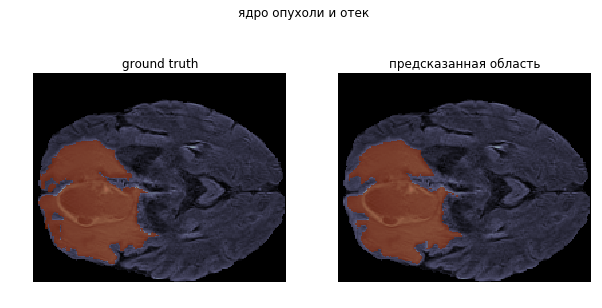

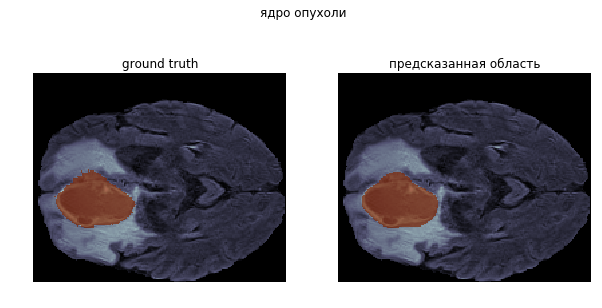

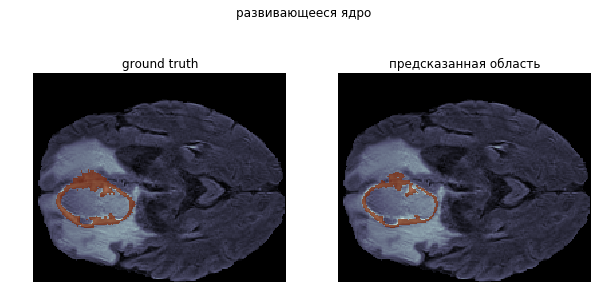

In [27]:
channel_ = 0 # канал по которому будет выбираться слайс для визуализации
num_img = 20
for channel in range(3):
    t = np.argmax(np.sum(all_gr_truth[-1][num_img, channel_], axis=(0,1)))
    plt.figure(figsize=(10,5))
    if channel == 0:
        plt.suptitle('ядро опухоли и отек')
    elif channel == 1:
        plt.suptitle('ядро опухоли')
    else:
        plt.suptitle('развивающееся ядро')
        
    #######
    plt.subplot(121)
    plt.axis('off')
    plt.title('ground truth')
    plt.imshow(all_data[-1][num_img, 3][..., t], cmap=cm.bone)
    plt.imshow(np.ma.masked_where(all_gr_truth[-1][num_img, channel][..., t]==0,
                                  all_gr_truth[-1][num_img, channel][..., t]), 
               alpha=0.7, cmap=cm.Oranges_r)
    #######
    plt.subplot(122)
    plt.axis('off')
    plt.title('предсказанная область')
    plt.imshow(all_data[-1][num_img, 3][..., t], cmap=cm.bone)
    plt.imshow(np.ma.masked_where(all_preds[-1][num_img, channel][..., t]==0,
                                  all_preds[-1][num_img, channel][..., t]), 
               alpha=0.7, cmap=cm.Oranges_r)

### Визуализация предсказанных биомаркеров для другого случайного пациента.

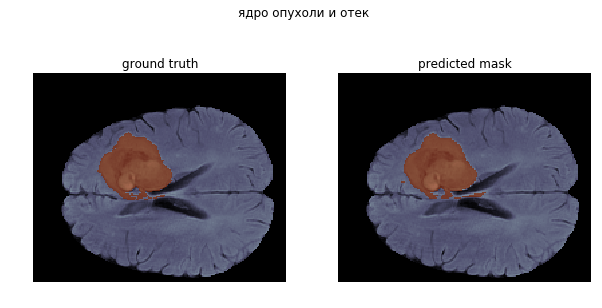

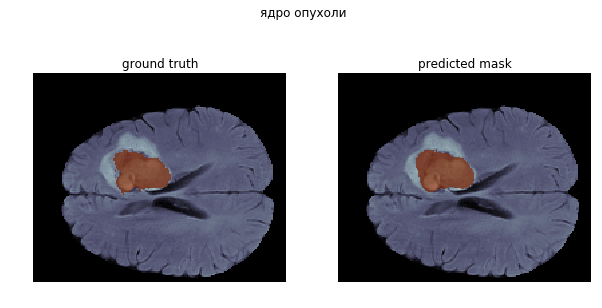

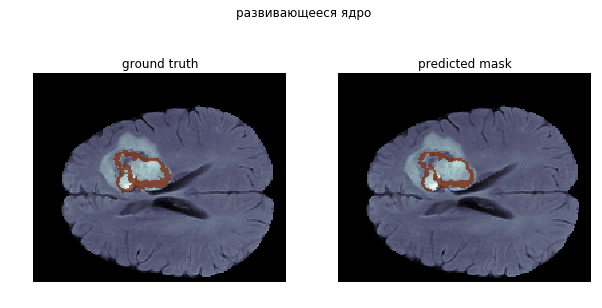

In [10]:
channel_ = 0 # канал по которому будет выбираться слайс для визуализации
num_img = 30
for channel in range(3):
    t = np.argmax(np.sum(all_gr_truth[-1][num_img, channel_], axis=(0,1)))
    plt.figure(figsize=(10,5))
    if channel == 0:
        plt.suptitle('ядро опухоли и отек')
    elif channel == 1:
        plt.suptitle('ядро опухоли')
    else:
        plt.suptitle('развивающееся ядро')
        
    #######
    plt.subplot(121)
    plt.axis('off')
    plt.title('ground truth')
    plt.imshow(all_data[-1][num_img, 3][..., t], cmap=cm.bone)
    plt.imshow(np.ma.masked_where(all_gr_truth[-1][num_img, channel][..., t]==0,
                                  all_gr_truth[-1][num_img, channel][..., t]), 
               alpha=0.7, cmap=cm.Oranges_r)
    #######
    plt.subplot(122)
    plt.axis('off')
    plt.title('предсказанная область')
    plt.imshow(all_data[-1][num_img, 3][..., t], cmap=cm.bone)
    plt.imshow(np.ma.masked_where(all_preds[-1][num_img, channel][..., t]==0,
                                  all_preds[-1][num_img, channel][..., t]), 
               alpha=0.7, cmap=cm.Oranges_r)

### Визуализация предсказанных биомаркеров для другого случайного пациента.

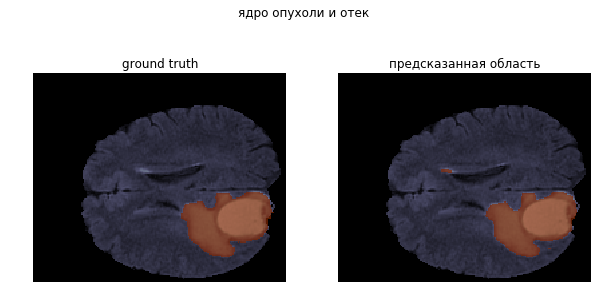

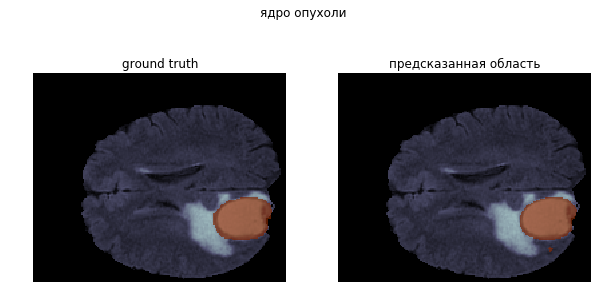

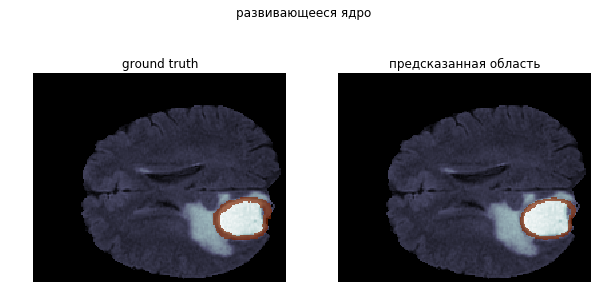

In [33]:
channel_ = 0 # канал по которому будет выбираться слайс для визуализации
num_img = 45
for channel in range(3):
    t = np.argmax(np.sum(all_gr_truth[-1][num_img, channel_], axis=(0,1)))
    plt.figure(figsize=(10,5))
    if channel == 0:
        plt.suptitle('ядро опухоли и отек')
    elif channel == 1:
        plt.suptitle('ядро опухоли')
    else:
        plt.suptitle('развивающееся ядро')
        
    #######
    plt.subplot(121)
    plt.axis('off')
    plt.title('ground truth')
    plt.imshow(all_data[-1][num_img, 3][..., t], cmap=cm.bone)
    plt.imshow(np.ma.masked_where(all_gr_truth[-1][num_img, channel][..., t]==0,
                                  all_gr_truth[-1][num_img, channel][..., t]), 
               alpha=0.7, cmap=cm.Oranges_r)
    #######
    plt.subplot(122)
    plt.axis('off')
    plt.title('предсказанная область')
    plt.imshow(all_data[-1][num_img, 3][..., t], cmap=cm.bone)
    plt.imshow(np.ma.masked_where(all_preds[-1][num_img, channel][..., t]==0,
                                  all_preds[-1][num_img, channel][..., t]), 
               alpha=0.7, cmap=cm.Oranges_r)

### Визуализация предсказанных биомаркеров для другого случайного пациента.

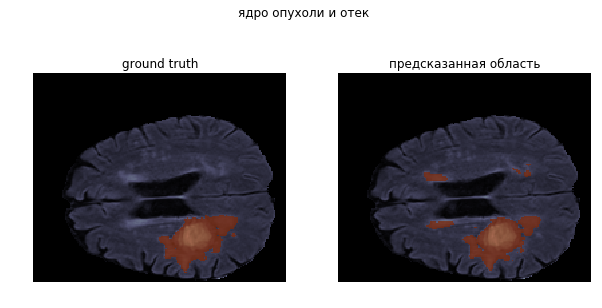

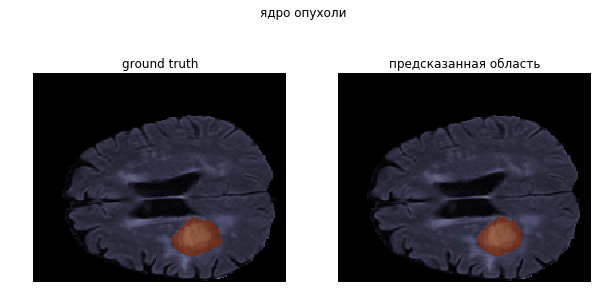

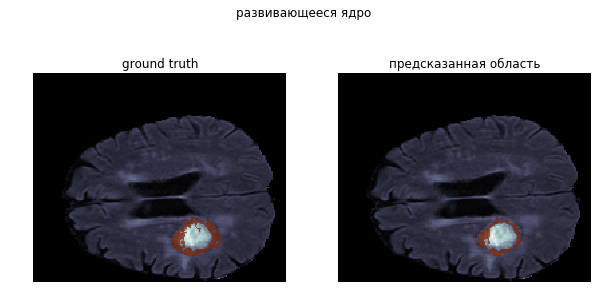

In [38]:
channel_ = 0 # канал по которому будет выбираться слайс для визуализации
num_img = 9
for channel in range(3):
    t = np.argmax(np.sum(all_gr_truth[-1][num_img, channel_], axis=(0,1)))
    plt.figure(figsize=(10,5))
    if channel == 0:
        plt.suptitle('ядро опухоли и отек')
    elif channel == 1:
        plt.suptitle('ядро опухоли')
    else:
        plt.suptitle('развивающееся ядро')
        
    #######
    plt.subplot(121)
    plt.axis('off')
    plt.title('ground truth')
    plt.imshow(all_data[-1][num_img, 3][..., t], cmap=cm.bone)
    plt.imshow(np.ma.masked_where(all_gr_truth[-1][num_img, channel][..., t]==0,
                                  all_gr_truth[-1][num_img, channel][..., t]), 
               alpha=0.7, cmap=cm.Oranges_r)
    #######
    plt.subplot(122)
    plt.axis('off')
    plt.title('предсказанная область')
    plt.imshow(all_data[-1][num_img, 3][..., t], cmap=cm.bone)
    plt.imshow(np.ma.masked_where(all_preds[-1][num_img, channel][..., t]==0,
                                  all_preds[-1][num_img, channel][..., t]), 
               alpha=0.7, cmap=cm.Oranges_r)